##### HAPPY AND SAD IMAGES

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip

--2021-05-03 04:50:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘happy-or-sad.zip.4’

happy-or-sad.zip.4  100%[===================>]   2.55M  --.-KB/s    in 0.01s   

2021-05-03 04:50:43 (227 MB/s) - ‘happy-or-sad.zip.4’ saved [2670333/2670333]



The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [ ]:
import os
import zipfile


local_zip = '/content/happy-or-sad.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/happy-or-sad')



zip_ref.close()

The contents of the .zip are extracted to the base directory `/content/happy-or-sad`, which in turn each contain `happy` and `sad` subdirectories.



One thing to pay attention to in this sample: We do not explicitly label the images as happy or sad.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'happy' directory and a 'sad' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [ ]:
# Directory with our training horse pictures
train_happy_dir = os.path.join('/content/happy-or-sad/happy')

# Directory with our training human pictures
train_sad_dir = os.path.join('/content/happy-or-sad/sad')


Now, let's see what the filenames look like in the `happy` and `sad` training directories:

In [ ]:
train_happy_names = os.listdir(train_happy_dir)
print(train_happy_names[:10])

train_sad_names = os.listdir(train_sad_dir)
print(train_sad_names[:10])



['happy2-12.png', 'happy1-00.png', 'happy2-02.png', 'happy1-07.png', 'happy2-06.png', 'happy2-18.png', 'happy1-12.png', 'happy2-19.png', 'happy2-17.png', 'happy2-05.png']
['sad1-13.png', 'sad2-06.png', 'sad2-14.png', 'sad1-02.png', 'sad1-09.png', 'sad1-17.png', 'sad2-02.png', 'sad2-15.png', 'sad1-04.png', 'sad1-19.png']


Let's find out the total number of happy and sad images in the directories:

In [ ]:
print('total training horse images:', len(os.listdir(train_happy_dir)))
print('total training human images:', len(os.listdir(train_sad_dir)))


total training horse images: 40
total training human images: 40


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 happy and 8 sad pictures. You can rerun the cell to see a fresh batch each time:

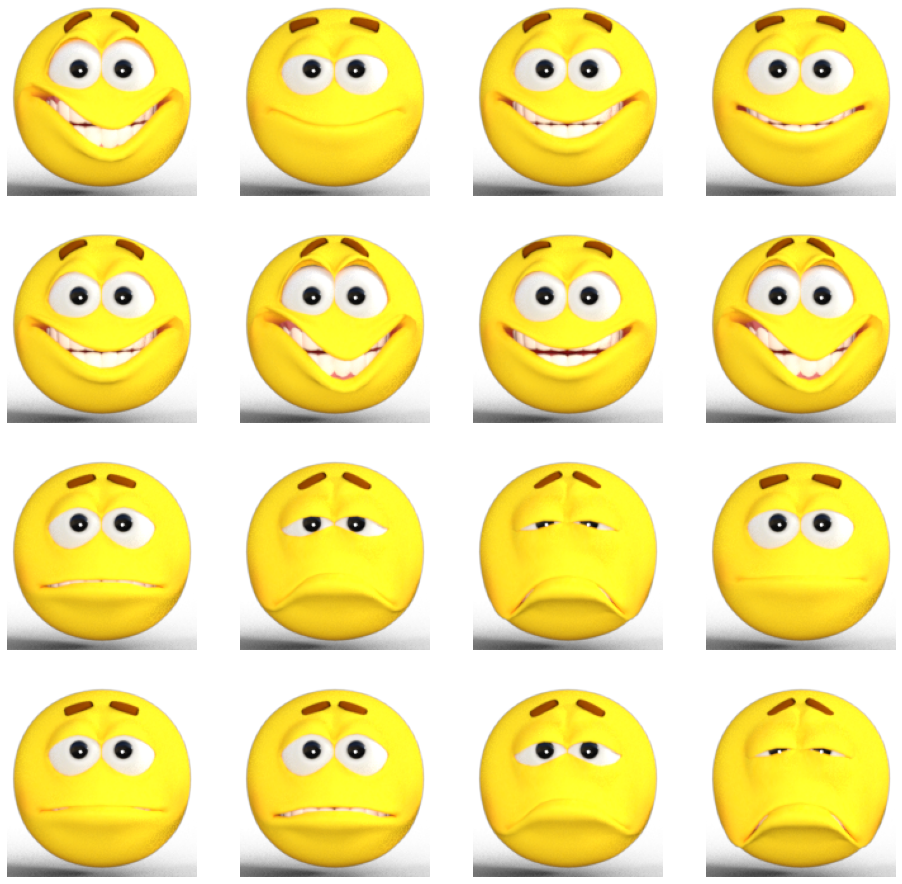

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_happy_pix = [os.path.join(train_happy_dir, fname) 
                for fname in train_happy_names[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(train_sad_dir, fname) 
                for fname in train_sad_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_happy_pix+next_sad_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [ ]:
import tensorflow as tf

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

My callbacks

In [ ]:
# MY CALLBACKS

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>=0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('happy') and 1 for the other ('sad')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

The model.summary() method call prints a summary of the NN 

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 78400)            

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/happy-or-sad',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')



Found 80 images belonging to 2 classes.


### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  #80/10
      epochs=15, 
      verbose=1, 
      callbacks=[callbacks])

Epoch 1/15
8/8 [==============================] - 1s 35ms/step - loss: 11.0213 - acc: 0.4215
Epoch 2/15
8/8 [==============================] - 0s 36ms/step - loss: 0.5354 - acc: 0.7172
Epoch 3/15
8/8 [==============================] - 0s 33ms/step - loss: 0.2069 - acc: 0.9510
Epoch 4/15
8/8 [==============================] - 0s 33ms/step - loss: 0.0595 - acc: 0.9795
Epoch 5/15
8/8 [==============================] - 0s 32ms/step - loss: 0.0336 - acc: 1.0000

Reached 99.9% accuracy so cancelling training!
